In [3]:
pip install influxdb

Note: you may need to restart the kernel to use updated packages.


In [50]:
import influxdb
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import pandas as pd
import datetime
import time
from matplotlib import pyplot

In [6]:
client = influxdb.InfluxDBClient(host='instance-influxdb', port=8086, username='user', password='ax3s4cd5fv6rbgt7hnz8jmu9',database='fabrikdaten')

In [58]:
result = client.query('select value FROM "carbon_monoxide" WHERE time >= now() - %s ;' %("1h"))
point = list(result.get_points(measurement='carbon_monoxide'))
output_array = []
for i in range(len(point)):
    x = point[i]
    try:
        x['time'] = datetime.datetime.strptime(x['time'], '%Y-%m-%dT%H:%M:%S.%fZ') #
    except:
        x['time'] = datetime.datetime.strptime(x['time'], '%Y-%m-%dT%H:%M:%SZ') #.%f
    x['time'] = x['time'].timestamp()
for p in point:
    output_array.append(list(p.values()))

output_array = np.array(output_array)
series = pd.Series([x[1] for x in output_array])

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                23704
Model:                 ARIMA(5, 1, 0)   Log Likelihood             -118547.686
Date:                Tue, 14 Dec 2021   AIC                         237107.371
Time:                        01:21:33   BIC                         237155.812
Sample:                             0   HQIC                        237123.090
                              - 23704                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5015      0.003   -192.707      0.000      -0.507      -0.496
ar.L2         -0.2798      0.005    -59.685      0.000      -0.289      -0.271
ar.L3         -0.1636      0.007    -22.994      0.0

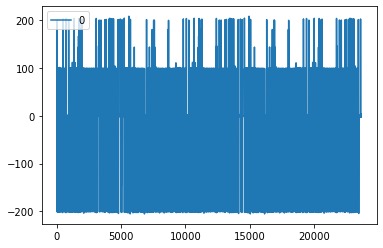

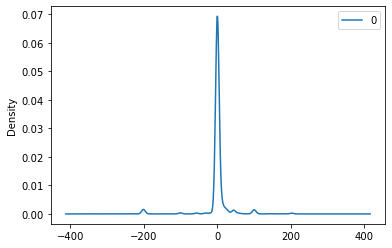

                  0
count  23704.000000
mean       0.007164
std       35.989391
min     -205.370343
25%       -0.476426
50%        0.000000
75%        0.495090
max      208.700000


In [59]:
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

In [60]:
fc = model_fit.forecast(steps=100)
print(fc)

23704    2.586201
23705    2.571121
23706    2.573938
23707    2.628482
23708    2.627739
           ...   
23799    2.600092
23800    2.600092
23801    2.600092
23802    2.600092
23803    2.600092
Name: predicted_mean, Length: 100, dtype: float64


In [62]:
base_item = {"measurement":"carbon_monoxide", "tags":{"machine":"room_lab"}, "fields":{"predict":None}, "timestamp":None }
ts = time.time()*1000
for elem in fc:
    ts += 10
    item = base_item
    item["fields"]["predict"] = elem
    item["timestamp"] = int(ts)
    client.write_points([item], time_precision="ms")

In [69]:
def forecast_function():
    client = influxdb.InfluxDBClient(host='instance-influxdb', port=8086, username='user', password='ax3s4cd5fv6rbgt7hnz8jmu9',database='fabrikdaten')
    result = client.query('select value FROM "carbon_monoxide" WHERE time >= now() - %s ;' %("1h"))
    point = list(result.get_points(measurement='carbon_monoxide'))
    output_array = []
    for i in range(len(point)):
        x = point[i]
        try:
            x['time'] = datetime.datetime.strptime(x['time'], '%Y-%m-%dT%H:%M:%S.%fZ') #
        except:
            x['time'] = datetime.datetime.strptime(x['time'], '%Y-%m-%dT%H:%M:%SZ') #.%f
        x['time'] = x['time'].timestamp()
    for p in point:
        output_array.append(list(p.values()))

    output_array = np.array(output_array)
    series = pd.Series([x[1] for x in output_array])
    model = ARIMA(series, order=(5,1,0))
    model_fit = model.fit()
    fc = model_fit.forecast(steps=10000)
    base_item = {"measurement":"carbon_monoxide", "tags":{"machine":"room_lab"}, "fields":{"predict":None}, "timestamp":None }
    ts = time.time()*1000
    for elem in fc:
        ts += 10
        item = base_item
        item["fields"]["predict"] = elem
        item["timestamp"] = int(ts)
        client.write_points([item], time_precision="ms")

In [ ]:
forecast_function()